In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter
from sklearn import preprocessing
from tqdm import tqdm
import random
import tensorflow as tf

In [2]:
os.listdir("./data")

['004#biGRU_diff.csv',
 'dlstm_diff.zip',
 'decode_train_neg.csv',
 'test2_match.csv',
 'test_match.csv',
 'decode_train_neg_spe.csv',
 'sqli_trian.zip',
 'train_match.csv',
 'sqli_submit_9878.json',
 'sqli_test_1',
 'test.csv',
 'train.csv',
 'test_neg_spe.csv',
 'sqli_test_2',
 'test_pos.csv',
 'sqli_train',
 'test_neg_pos.csv',
 'dlstm_diff.csv',
 'decode_train_neg_pos.csv',
 'decode_train_pos.csv',
 '004#dlstm_diff.csv',
 'test2.csv',
 'sqli_test_2.zip',
 'test_neg.csv',
 'sqli_test_1-.zip',
 '007#bi-GRU-MaxPool.csv']

In [3]:
tf.reset_default_graph()

# Parameters
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = 50

# Network Parameters
seq_max_len = 300 # Sequence max length
vocab_len = 69
n_hidden = 32 # hidden layer num of features
n_classes = 2 # linear sequence or not

# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, vocab_len])
y = tf.placeholder("float", [None, n_classes])
# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None,])

# # Define weights
# weights = {
#     'out': tf.Variable(tf.random_normal([100, n_classes], seed=2018))
# }
# biases = {
#     'out': tf.Variable(tf.random_normal([n_classes], seed=2018))
# }



# Get lstm cell output, providing 'sequence_length' will perform dynamic calculation.
with tf.variable_scope("LSTM") as scope:
    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, state_is_tuple=True)
    print("lstm_cell", lstm_cell)
#     init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
#     print("init_state", lstm_cell)
    outputs, states = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32)
    print("outputs", outputs)
#     print("states", states)
    
with tf.variable_scope("softmax"):
    softmax_w = tf.get_variable("softmax_w",
                                shape=[n_hidden, n_classes],
                                initializer=tf.truncated_normal_initializer(stddev=0.05, seed=2018),
                                dtype=tf.float32)
    softmax_b = tf.get_variable("softmax_b",
                                shape=[n_classes],
                                initializer=tf.constant_initializer(value=0.),
                                dtype=tf.float32)
    reshape = tf.reshape(outputs, [-1, n_hidden])
    xw_plus_b = tf.nn.xw_plus_b(reshape, softmax_w, softmax_b)
    print("xw_plus_b:", xw_plus_b)
    logits = tf.reshape(xw_plus_b, [-1, seq_max_len, n_classes])
    print("logits:", logits)
    logits_softmax = tf.nn.softmax(logits)
    
with tf.variable_scope("output"):
    # Hack to build the indexing and retrieve the right output.
    batch_size_ = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size_) * seq_max_len + (seqlen - 1)
    # Indexing
    pred = tf.gather(tf.reshape(logits, [-1, n_classes]), index)
    print("pred", pred)


with tf.name_scope("loss"):
#     print(outputs)
    # Linear activation, using outputs computed above
#     pred = tf.matmul(weights['out'], outputs) + biases['out']

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    

with tf.name_scope("train"):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
with tf.name_scope("valid"):
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

lstm_cell <tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell object at 0x7fac8899eeb8>
outputs Tensor("LSTM/rnn/transpose:0", shape=(?, 300, 32), dtype=float32)
xw_plus_b: Tensor("softmax/xw_plus_b:0", shape=(?, 2), dtype=float32)
logits: Tensor("softmax/Reshape_1:0", shape=(?, 300, 2), dtype=float32)
pred Tensor("output/Gather:0", shape=(?, 2), dtype=float32)


/home/renxinzhang/.conda/envs/tf-gpu-1.3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [4]:
vocab = [v for v in ' !"#$%&\'()*+,-./0123456789:;<=>?@[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~']
print("lable encoder vocab")
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(vocab)
print(label_encoder.classes_)

lable encoder vocab
[' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1'
 '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' '[' '\\' ']'
 '^' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '{' '|' '}' '~']


In [26]:
def get_train_pos():
    train_pd = pd.read_csv("./data/test_pos.csv")
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [1] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
    return x_batch_pad, x_batch_size, y_batch_pad

In [21]:
def get_train_neg():
    train_pd = pd.read_csv("./data/test_neg.csv")
    train_pd = train_pd.dropna()
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [0] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
    return x_batch_pad, x_batch_size, y_batch_pad

In [10]:
def get_train_neg_pos():
    train_pd = pd.read_csv("./data/test_neg_pos.csv")
    train_pd = train_pd.dropna()
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [0] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
    return x_batch_pad, x_batch_size, y_batch_pad

In [5]:
def get_train_neg_sep():
    train_pd = pd.read_csv("./data/test_neg_spe.csv")
    train_pd = train_pd.dropna()
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [0] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
    return x_batch_pad, x_batch_size, y_batch_pad

In [11]:
# test_data, test_seqlen, test_label = get_train_pos()
# test_data, test_seqlen, test_label = get_train_neg()
test_data, test_seqlen, test_label = get_train_neg_pos()
# test_data, test_seqlen, test_label = get_train_neg_sep()
test_data, test_seqlen, test_label = np.array(test_data), np.array(test_seqlen), np.array(test_label)
print(test_data.shape, test_seqlen.shape, test_label.shape)

100%|██████████| 9488/9488 [00:00<00:00, 227111.18it/s]

get word_list & label encoder



100%|██████████| 9488/9488 [00:00<00:00, 75777.39it/s]

padding & one-hot x data


padding & one-hot y data
(9488, 300, 69) (9488,) (9488, 2)


In [12]:
LOG_DIR = "./logs/010_BasicModel/"
saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
module_file = tf.train.latest_checkpoint(LOG_DIR)

test_pred = ''
# Start training
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
with tf.Session(config=config) as sess:
    
    saver.restore(sess, module_file)

    # Calculate accuracy
#     test_data = sqli_batch.test_x
#     test_label = sqli_batch.test_y
#     test_seqlen = sqli_batch.test_size
    test_pred, test_acc, test_output = sess.run([pred, accuracy, logits_softmax], feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
    print("Testing Accuracy:", test_acc)

INFO:tensorflow:Restoring parameters from ./logs/010_BasicModel/sqli.ckpt-500
Testing Accuracy: 0.990831


In [13]:
from sklearn.utils.extmath import softmax

test_pred_label = np.argmax(test_pred, 1)
test_real_label = np.argmax(test_label, 1)
test_diff = test_pred_label != test_real_label
test_diff_index = np.where(test_diff == True)[0]
print("diff len:", len(test_diff_index))

# test_data = sqli_batch.test_x
# test_label = sqli_batch.test_y
# test_seqlen = sqli_batch.test_size

diff_x = test_data[test_diff_index]
diff_x = np.argmax(diff_x, 2)

diff_y = test_label[test_diff_index]
diff_y = np.argmax(diff_y, 1)

test_pred_softmax = softmax(test_pred)
pred_y = test_pred_softmax[test_diff_index]
pred_y = [item[1] for item in pred_y]
pred_class = test_pred_label[test_diff_index]

diff_x = [label_encoder.inverse_transform(item) for item in diff_x]
diff_value = ["".join(list(item)).strip() for item in diff_x]

diff_pd = pd.DataFrame(diff_value, columns=['value'])
diff_pd['label'] = diff_y
diff_pd['pred'] = pred_y
diff_pd['plabel'] = pred_class
diff_pd['id'] = test_diff_index
diff_pd.to_csv("./result/neg_pos_diff.csv", index=False)
diff_pd

diff len: 87


,value,label,pred,plabel,id
0,leigh is one of pass the rare directors who fe...,0,0.707095,1,126
1,what lee union does char() so marvelously comp...,0,0.992727,1,158
2,what emerges is select an unsettling picture o...,0,0.790217,1,317
3,instead union null of a (47) witty expose on t...,0,0.946089,1,328
4,parts seem like they union were lifted from te...,0,0.644122,1,659
5,turturro is (union) fabulously funny and union...,0,0.610523,1,1133
6,about a boy select vividly recalls the (union)...,0,0.562963,1,1157
7,'interesante y version disfrutable trabajo gra...,0,0.567830,1,1229
8,in addition to sporting union password one of ...,0,0.906865,1,1403
9,imagine a select ( scenario where bergman tabl...,0,0.539791,1,1575


In [16]:
show_index = 68
showitem = test_data[show_index]
showitem_len = test_seqlen[show_index]
print(showitem.shape)
showitem = np.argmax(showitem, 1)
print(showitem.shape)
heatmap_x = [label_encoder.inverse_transform(item) for item in showitem]
heatmap_x = heatmap_x[:showitem_len]
print(showitem_len)
heatmap_y = test_output[show_index][:showitem_len]
heatmap_y = [[row[1] for row in heatmap_y]]

(300, 69)
(300,)
45


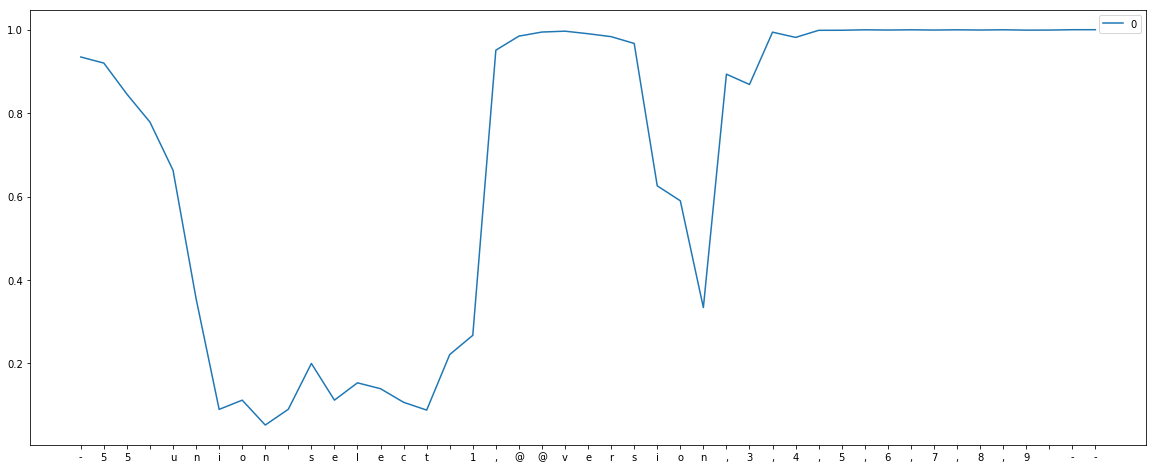

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
for i in range(1):
    plt.plot(heatmap_y[i][:len(heatmap_x)], label=str(i))
xticks = range(0,len(heatmap_x))
ax.set_xticks(xticks) # major ticks
ax.set_xticklabels(heatmap_x)   # labels should be 'unicode'
plt.legend(loc='upper right')
plt.show()